# Import libraries

In [1]:
import os
import glob
import pathlib
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler , TensorBoard , ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Get path

In [2]:
base_dir = './Datasets'
train_dir = pathlib.Path(base_dir)

# Get class of each image

In [3]:
CLASS_NAMES = np.array([item for item in glob.glob('./Datasets/UTKFace/*')])
CLASS_AGE  = np.array([item.split('/') for item in CLASS_NAMES])
CLASS_AGE = np.array([i[-1].split('_') for i in CLASS_AGE])
CLASS_AGE = [int(i[0]) for i in CLASS_AGE]
len(CLASS_AGE)

23708

In [4]:
CLASS_NAMES = np.array([item for item in glob.glob('./Datasets/UTKFace/*')])
CLASS_SEX = np.array([item.split('/') for item in CLASS_NAMES])
CLASS_SEX = np.array([i[-1].split('_') for i in CLASS_SEX])
CLASS_SEX = np.array([int(i[1]) for i in CLASS_SEX])
len(CLASS_SEX)

23708

# Get data and split them

In [5]:
full_dataset = tf.data.Dataset.list_files(str(train_dir/'UTKFace/*'))

In [6]:
validation_size = 0.2
dataset_size = len(list(full_dataset))
print('dataset size is {}'.format(dataset_size))
train_size = int((1-validation_size)*dataset_size)
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

dataset size is 23708


# Required functions

In [7]:
def get_init_epoch(path):
    return int(path.split('-')[-2].split('.')[-1])

# def agument(image):
#     image = tf.image.resize_with_crop_or_pad(image , 220,220)
#     image = tf.image.random_crop(image , size=[200,200,3])
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     return image

def get_label_age(file_path):
    parts = tf.strings.split(file_path ,os.path.sep)[-1]
    parts = tf.strings.split(parts , sep='_')
    parts = tf.strings.to_number(parts[0] , out_type=tf.dtypes.float32)
    return parts

def get_label_sex(file_path):
    parts = tf.strings.split(file_path ,os.path.sep)[-1]
    parts = tf.strings.split(parts , sep='_')
    parts = tf.strings.to_number(parts[1] , out_type=tf.dtypes.float32)
    return parts

def normalize(image):
    image = (image / 127.5) -1
    return image

def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img , 3 ,expand_animations=False)
    img = tf.cast(img , tf.float32)
    return img

def load_img_with_label(image_path):
    age = get_label_age(image_path)
    sex = get_label_sex(image_path)
    img = load_img(image_path)
    return img , sex , age

def resize(img , height , width):
    img = tf.image.resize(img , (height , width) , method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def load_img_train(image_path):
    img , sex , age = load_img_with_label(image_path)
    img = resize(img , 224 , 224)
#     img = agument(img)
    img = normalize(img)
    return img, {"sex_model": sex ,"age_model": age}

def load_img_test(image_path):
    img , sex , age = load_img_with_label(image_path)
    img = resize(img , 224 , 224)
    img = normalize(img)
    return img , {"sex_model": sex , "age_model": age}


# Define callbacks
#### `Tensorboard`
#### ` Learning Rate scheduler`
#### `check point`

In [8]:
def lr_scheduler(epoch, lr):
    if epoch < 20:
        return 0.001
    elif epoch < 50:
        return 0.0001
    else:
        return 0.00001
learningratescheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler , verbose=1)

In [9]:
logdir = 'age_sex_tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [10]:
# os.makedirs("training_3", exist_ok=True)
ckpt_callback = ModelCheckpoint(filepath='age_sex_checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss')

# Load data

In [11]:
batch_size = 20

In [12]:
train_datasets = train_dataset.map(load_img_train , num_parallel_calls=AUTOTUNE)
train_datasets = train_datasets.batch(batch_size , num_parallel_calls=AUTOTUNE)

validation_datasets = validation_dataset.map(load_img_test , num_parallel_calls=AUTOTUNE)
validation_datasets = validation_datasets.batch(batch_size , num_parallel_calls=AUTOTUNE)

In [13]:
train_dataset

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

## Load pretrain model `MobileNetV2`

In [14]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(224 , 224 , 3))

In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [17]:
base_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

# Define backbone model two output and one input with functional model

In [18]:
pre_output = base_model.output
flatten = tf.keras.layers.Flatten()(pre_output)
# flatten = inputs


sex = tf.keras.layers.Dense(64, activation="relu")(flatten)
sex = tf.keras.layers.Dense(128, activation="relu")(sex)
sex = tf.keras.layers.Dropout(0.5)(sex)
sex_output = tf.keras.layers.Dense(1, activation="sigmoid" , name='sex_model')(sex)

age = tf.keras.layers.Dense(64, activation="relu")(flatten)
age = tf.keras.layers.Dense(128, activation="relu")(age)
age = tf.keras.layers.Dense(256, activation="relu")(age)
age = tf.keras.layers.Dropout(0.5)(age)
age_output = tf.keras.layers.Dense(1, activation="linear", name='age_model')(age)


model = tf.keras.models.Model(inputs=base_model.input, outputs=(age_output , sex_output))

## Plot model architectuer

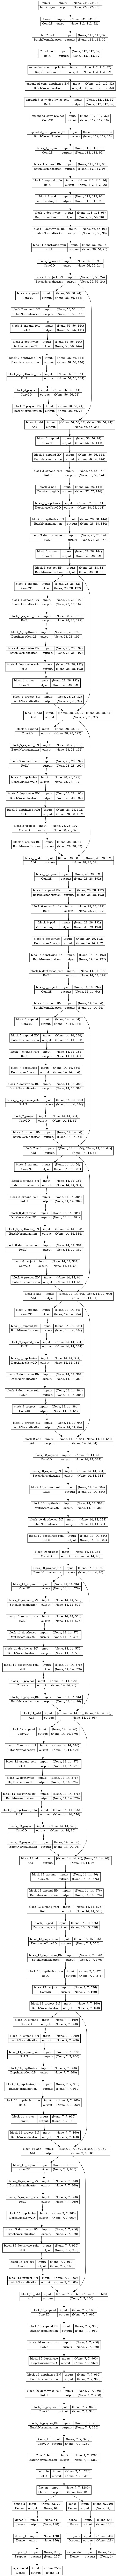

In [19]:
img_file = './architecture1.png'   ##save picture
tf.keras.utils.plot_model(model,to_file=img_file,show_shapes=True, show_layer_names=True)

# Define losses, metrics and compile model

In [20]:
losses = {
    "sex_model": "binary_crossentropy",
    "age_model": "mean_absolute_error",
}

In [21]:
metrics = {
    "sex_model": "accuracy",
    "age_model": "mean_absolute_error",
}

In [22]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=metrics,
              loss=losses)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

 sex_model (Dense)              (None, 1)            129         ['dropout[0][0]']                
                                                                                                  
Total params: 10,336,322
Trainable params: 8,078,338
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


# Run model

In [24]:
history = model.fit(train_datasets,
              validation_data=validation_datasets,
              callbacks=[tensorboard_callback, ckpt_callback],
              epochs=300)

Epoch 1/300
949/949 [==============================] - 46s 45ms/step - loss: 10.6616 - age_model_loss: 10.1632 - sex_model_loss: 0.4984 - age_model_mean_absolute_error: 10.1632 - sex_model_accuracy: 0.7712 - val_loss: 7.9600 - val_age_model_loss: 7.5464 - val_sex_model_loss: 0.4136 - val_age_model_mean_absolute_error: 7.5464 - val_sex_model_accuracy: 0.7499
Epoch 2/300
949/949 [==============================] - 42s 44ms/step - loss: 8.8333 - age_model_loss: 8.5208 - sex_model_loss: 0.3125 - age_model_mean_absolute_error: 8.5208 - sex_model_accuracy: 0.8524 - val_loss: 6.8876 - val_age_model_loss: 6.6437 - val_sex_model_loss: 0.2440 - val_age_model_mean_absolute_error: 6.6437 - val_sex_model_accuracy: 0.8910
Epoch 3/300
949/949 [==============================] - 42s 44ms/step - loss: 8.0054 - age_model_loss: 7.7547 - sex_model_loss: 0.2508 - age_model_mean_absolute_error: 7.7547 - sex_model_accuracy: 0.8840 - val_loss: 7.0364 - val_age_model_loss: 6.8293 - val_sex_model_loss: 0.2071 - v

Epoch 24/300
949/949 [==============================] - 42s 44ms/step - loss: 4.4239 - age_model_loss: 4.3716 - sex_model_loss: 0.0523 - age_model_mean_absolute_error: 4.3716 - sex_model_accuracy: 0.9798 - val_loss: 3.4578 - val_age_model_loss: 3.3725 - val_sex_model_loss: 0.0853 - val_age_model_mean_absolute_error: 3.3725 - val_sex_model_accuracy: 0.9639
Epoch 25/300
949/949 [==============================] - 42s 44ms/step - loss: 4.4372 - age_model_loss: 4.3878 - sex_model_loss: 0.0493 - age_model_mean_absolute_error: 4.3878 - sex_model_accuracy: 0.9822 - val_loss: 3.2352 - val_age_model_loss: 3.2008 - val_sex_model_loss: 0.0344 - val_age_model_mean_absolute_error: 3.2008 - val_sex_model_accuracy: 0.9878
Epoch 26/300
949/949 [==============================] - 42s 44ms/step - loss: 4.3250 - age_model_loss: 4.2806 - sex_model_loss: 0.0445 - age_model_mean_absolute_error: 4.2806 - sex_model_accuracy: 0.9837 - val_loss: 3.0262 - val_age_model_loss: 2.9972 - val_sex_model_loss: 0.0290 - v

Epoch 47/300
949/949 [==============================] - 42s 44ms/step - loss: 3.5616 - age_model_loss: 3.5307 - sex_model_loss: 0.0309 - age_model_mean_absolute_error: 3.5307 - sex_model_accuracy: 0.9892 - val_loss: 2.3831 - val_age_model_loss: 2.3495 - val_sex_model_loss: 0.0336 - val_age_model_mean_absolute_error: 2.3495 - val_sex_model_accuracy: 0.9873
Epoch 48/300
949/949 [==============================] - 42s 44ms/step - loss: 3.5660 - age_model_loss: 3.5376 - sex_model_loss: 0.0284 - age_model_mean_absolute_error: 3.5376 - sex_model_accuracy: 0.9904 - val_loss: 2.3565 - val_age_model_loss: 2.3333 - val_sex_model_loss: 0.0231 - val_age_model_mean_absolute_error: 2.3333 - val_sex_model_accuracy: 0.9914
Epoch 49/300
949/949 [==============================] - 42s 44ms/step - loss: 3.5247 - age_model_loss: 3.4931 - sex_model_loss: 0.0316 - age_model_mean_absolute_error: 3.4931 - sex_model_accuracy: 0.9890 - val_loss: 2.5817 - val_age_model_loss: 2.5638 - val_sex_model_loss: 0.0179 - v

Epoch 70/300
949/949 [==============================] - 43s 45ms/step - loss: 3.2176 - age_model_loss: 3.2001 - sex_model_loss: 0.0175 - age_model_mean_absolute_error: 3.2001 - sex_model_accuracy: 0.9943 - val_loss: 2.5195 - val_age_model_loss: 2.5009 - val_sex_model_loss: 0.0186 - val_age_model_mean_absolute_error: 2.5009 - val_sex_model_accuracy: 0.9937
Epoch 71/300
949/949 [==============================] - 43s 45ms/step - loss: 3.3151 - age_model_loss: 3.2910 - sex_model_loss: 0.0242 - age_model_mean_absolute_error: 3.2910 - sex_model_accuracy: 0.9915 - val_loss: 1.8791 - val_age_model_loss: 1.8510 - val_sex_model_loss: 0.0281 - val_age_model_mean_absolute_error: 1.8510 - val_sex_model_accuracy: 0.9890
Epoch 72/300
949/949 [==============================] - 43s 45ms/step - loss: 3.1714 - age_model_loss: 3.1462 - sex_model_loss: 0.0253 - age_model_mean_absolute_error: 3.1462 - sex_model_accuracy: 0.9919 - val_loss: 2.1483 - val_age_model_loss: 2.1280 - val_sex_model_loss: 0.0204 - v

Epoch 93/300
949/949 [==============================] - 41s 43ms/step - loss: 2.9402 - age_model_loss: 2.9198 - sex_model_loss: 0.0204 - age_model_mean_absolute_error: 2.9198 - sex_model_accuracy: 0.9929 - val_loss: 1.9913 - val_age_model_loss: 1.9701 - val_sex_model_loss: 0.0212 - val_age_model_mean_absolute_error: 1.9701 - val_sex_model_accuracy: 0.9933
Epoch 94/300
949/949 [==============================] - 41s 43ms/step - loss: 2.9402 - age_model_loss: 2.9183 - sex_model_loss: 0.0219 - age_model_mean_absolute_error: 2.9183 - sex_model_accuracy: 0.9926 - val_loss: 1.7370 - val_age_model_loss: 1.7231 - val_sex_model_loss: 0.0138 - val_age_model_mean_absolute_error: 1.7231 - val_sex_model_accuracy: 0.9954
Epoch 95/300
949/949 [==============================] - 41s 43ms/step - loss: 2.9110 - age_model_loss: 2.8920 - sex_model_loss: 0.0190 - age_model_mean_absolute_error: 2.8920 - sex_model_accuracy: 0.9933 - val_loss: 1.7154 - val_age_model_loss: 1.6975 - val_sex_model_loss: 0.0179 - v

Epoch 116/300
949/949 [==============================] - 41s 43ms/step - loss: 2.7545 - age_model_loss: 2.7371 - sex_model_loss: 0.0175 - age_model_mean_absolute_error: 2.7371 - sex_model_accuracy: 0.9938 - val_loss: 1.6390 - val_age_model_loss: 1.6231 - val_sex_model_loss: 0.0159 - val_age_model_mean_absolute_error: 1.6231 - val_sex_model_accuracy: 0.9941
Epoch 117/300
949/949 [==============================] - 41s 43ms/step - loss: 2.7714 - age_model_loss: 2.7498 - sex_model_loss: 0.0216 - age_model_mean_absolute_error: 2.7498 - sex_model_accuracy: 0.9931 - val_loss: 2.3918 - val_age_model_loss: 2.3756 - val_sex_model_loss: 0.0162 - val_age_model_mean_absolute_error: 2.3756 - val_sex_model_accuracy: 0.9943
Epoch 118/300
949/949 [==============================] - 41s 43ms/step - loss: 2.7648 - age_model_loss: 2.7448 - sex_model_loss: 0.0200 - age_model_mean_absolute_error: 2.7448 - sex_model_accuracy: 0.9937 - val_loss: 1.9454 - val_age_model_loss: 1.9299 - val_sex_model_loss: 0.0155 

Epoch 139/300
949/949 [==============================] - 41s 43ms/step - loss: 2.6413 - age_model_loss: 2.6210 - sex_model_loss: 0.0203 - age_model_mean_absolute_error: 2.6210 - sex_model_accuracy: 0.9933 - val_loss: 1.5088 - val_age_model_loss: 1.4950 - val_sex_model_loss: 0.0138 - val_age_model_mean_absolute_error: 1.4950 - val_sex_model_accuracy: 0.9956
Epoch 140/300
949/949 [==============================] - 41s 43ms/step - loss: 2.6222 - age_model_loss: 2.6040 - sex_model_loss: 0.0182 - age_model_mean_absolute_error: 2.6040 - sex_model_accuracy: 0.9939 - val_loss: 1.6235 - val_age_model_loss: 1.6094 - val_sex_model_loss: 0.0141 - val_age_model_mean_absolute_error: 1.6094 - val_sex_model_accuracy: 0.9951
Epoch 141/300
949/949 [==============================] - 41s 43ms/step - loss: 2.5987 - age_model_loss: 2.5846 - sex_model_loss: 0.0141 - age_model_mean_absolute_error: 2.5846 - sex_model_accuracy: 0.9953 - val_loss: 1.7567 - val_age_model_loss: 1.7444 - val_sex_model_loss: 0.0124 

Epoch 162/300
949/949 [==============================] - 42s 44ms/step - loss: 2.5105 - age_model_loss: 2.4942 - sex_model_loss: 0.0163 - age_model_mean_absolute_error: 2.4942 - sex_model_accuracy: 0.9944 - val_loss: 1.4459 - val_age_model_loss: 1.4287 - val_sex_model_loss: 0.0172 - val_age_model_mean_absolute_error: 1.4287 - val_sex_model_accuracy: 0.9935
Epoch 163/300
949/949 [==============================] - 42s 44ms/step - loss: 2.4907 - age_model_loss: 2.4756 - sex_model_loss: 0.0151 - age_model_mean_absolute_error: 2.4756 - sex_model_accuracy: 0.9947 - val_loss: 1.4781 - val_age_model_loss: 1.4615 - val_sex_model_loss: 0.0166 - val_age_model_mean_absolute_error: 1.4615 - val_sex_model_accuracy: 0.9939
Epoch 164/300
949/949 [==============================] - 42s 44ms/step - loss: 2.5397 - age_model_loss: 2.5190 - sex_model_loss: 0.0207 - age_model_mean_absolute_error: 2.5190 - sex_model_accuracy: 0.9933 - val_loss: 1.7166 - val_age_model_loss: 1.6978 - val_sex_model_loss: 0.0188 

Epoch 185/300
949/949 [==============================] - 41s 43ms/step - loss: 2.4369 - age_model_loss: 2.4172 - sex_model_loss: 0.0197 - age_model_mean_absolute_error: 2.4172 - sex_model_accuracy: 0.9939 - val_loss: 1.4209 - val_age_model_loss: 1.4055 - val_sex_model_loss: 0.0154 - val_age_model_mean_absolute_error: 1.4055 - val_sex_model_accuracy: 0.9945
Epoch 186/300
949/949 [==============================] - 41s 43ms/step - loss: 2.4771 - age_model_loss: 2.4592 - sex_model_loss: 0.0179 - age_model_mean_absolute_error: 2.4592 - sex_model_accuracy: 0.9941 - val_loss: 1.3846 - val_age_model_loss: 1.3691 - val_sex_model_loss: 0.0155 - val_age_model_mean_absolute_error: 1.3691 - val_sex_model_accuracy: 0.9943
Epoch 187/300
949/949 [==============================] - 41s 43ms/step - loss: 2.4153 - age_model_loss: 2.3978 - sex_model_loss: 0.0175 - age_model_mean_absolute_error: 2.3978 - sex_model_accuracy: 0.9946 - val_loss: 1.7585 - val_age_model_loss: 1.7348 - val_sex_model_loss: 0.0237 

Epoch 208/300
949/949 [==============================] - 40s 43ms/step - loss: 2.3166 - age_model_loss: 2.2973 - sex_model_loss: 0.0193 - age_model_mean_absolute_error: 2.2973 - sex_model_accuracy: 0.9939 - val_loss: 1.2876 - val_age_model_loss: 1.2755 - val_sex_model_loss: 0.0122 - val_age_model_mean_absolute_error: 1.2755 - val_sex_model_accuracy: 0.9962
Epoch 209/300
949/949 [==============================] - 40s 43ms/step - loss: 2.3219 - age_model_loss: 2.3039 - sex_model_loss: 0.0180 - age_model_mean_absolute_error: 2.3039 - sex_model_accuracy: 0.9945 - val_loss: 1.5358 - val_age_model_loss: 1.5228 - val_sex_model_loss: 0.0130 - val_age_model_mean_absolute_error: 1.5228 - val_sex_model_accuracy: 0.9958
Epoch 210/300
949/949 [==============================] - 40s 43ms/step - loss: 2.3131 - age_model_loss: 2.2987 - sex_model_loss: 0.0144 - age_model_mean_absolute_error: 2.2987 - sex_model_accuracy: 0.9951 - val_loss: 1.2928 - val_age_model_loss: 1.2822 - val_sex_model_loss: 0.0106 

Epoch 231/300
949/949 [==============================] - 41s 43ms/step - loss: 2.2592 - age_model_loss: 2.2452 - sex_model_loss: 0.0140 - age_model_mean_absolute_error: 2.2452 - sex_model_accuracy: 0.9951 - val_loss: 1.6417 - val_age_model_loss: 1.6238 - val_sex_model_loss: 0.0179 - val_age_model_mean_absolute_error: 1.6238 - val_sex_model_accuracy: 0.9937
Epoch 232/300
949/949 [==============================] - 40s 43ms/step - loss: 2.2558 - age_model_loss: 2.2369 - sex_model_loss: 0.0189 - age_model_mean_absolute_error: 2.2369 - sex_model_accuracy: 0.9943 - val_loss: 1.5535 - val_age_model_loss: 1.5306 - val_sex_model_loss: 0.0229 - val_age_model_mean_absolute_error: 1.5306 - val_sex_model_accuracy: 0.9939
Epoch 233/300
949/949 [==============================] - 41s 43ms/step - loss: 2.2792 - age_model_loss: 2.2644 - sex_model_loss: 0.0148 - age_model_mean_absolute_error: 2.2644 - sex_model_accuracy: 0.9955 - val_loss: 1.2129 - val_age_model_loss: 1.2025 - val_sex_model_loss: 0.0104 

Epoch 254/300
949/949 [==============================] - 41s 43ms/step - loss: 2.2361 - age_model_loss: 2.2206 - sex_model_loss: 0.0155 - age_model_mean_absolute_error: 2.2206 - sex_model_accuracy: 0.9951 - val_loss: 1.2040 - val_age_model_loss: 1.1933 - val_sex_model_loss: 0.0108 - val_age_model_mean_absolute_error: 1.1933 - val_sex_model_accuracy: 0.9970
Epoch 255/300
949/949 [==============================] - 41s 43ms/step - loss: 2.2084 - age_model_loss: 2.1928 - sex_model_loss: 0.0156 - age_model_mean_absolute_error: 2.1928 - sex_model_accuracy: 0.9945 - val_loss: 1.4619 - val_age_model_loss: 1.4473 - val_sex_model_loss: 0.0146 - val_age_model_mean_absolute_error: 1.4473 - val_sex_model_accuracy: 0.9951
Epoch 256/300
949/949 [==============================] - 41s 43ms/step - loss: 2.2034 - age_model_loss: 2.1907 - sex_model_loss: 0.0127 - age_model_mean_absolute_error: 2.1907 - sex_model_accuracy: 0.9957 - val_loss: 1.4624 - val_age_model_loss: 1.4505 - val_sex_model_loss: 0.0119 

Epoch 277/300
949/949 [==============================] - 41s 43ms/step - loss: 2.1456 - age_model_loss: 2.1302 - sex_model_loss: 0.0154 - age_model_mean_absolute_error: 2.1302 - sex_model_accuracy: 0.9949 - val_loss: 1.4301 - val_age_model_loss: 1.4145 - val_sex_model_loss: 0.0156 - val_age_model_mean_absolute_error: 1.4145 - val_sex_model_accuracy: 0.9956
Epoch 278/300
949/949 [==============================] - 41s 43ms/step - loss: 2.1273 - age_model_loss: 2.1124 - sex_model_loss: 0.0148 - age_model_mean_absolute_error: 2.1124 - sex_model_accuracy: 0.9954 - val_loss: 1.2301 - val_age_model_loss: 1.2178 - val_sex_model_loss: 0.0123 - val_age_model_mean_absolute_error: 1.2178 - val_sex_model_accuracy: 0.9958
Epoch 279/300
949/949 [==============================] - 41s 43ms/step - loss: 2.0995 - age_model_loss: 2.0845 - sex_model_loss: 0.0150 - age_model_mean_absolute_error: 2.0845 - sex_model_accuracy: 0.9951 - val_loss: 1.2424 - val_age_model_loss: 1.2308 - val_sex_model_loss: 0.0116 

Epoch 300/300
949/949 [==============================] - 41s 43ms/step - loss: 2.0602 - age_model_loss: 2.0428 - sex_model_loss: 0.0174 - age_model_mean_absolute_error: 2.0428 - sex_model_accuracy: 0.9940 - val_loss: 1.3097 - val_age_model_loss: 1.2842 - val_sex_model_loss: 0.0255 - val_age_model_mean_absolute_error: 1.2842 - val_sex_model_accuracy: 0.9933


# Resume steps

In [25]:
# checkpoint_path = 'age_sex_checkpoint/weights.42-2.45.hdf5'
# model = tf.keras.models.load_model(checkpoint_path)
# initial_epoch = get_init_epoch(checkpoint_path)

# history = model.fit(train_dataset_,
#               validation_data=validation_dataset_,
#               callbacks=[tensorboard_callback ,ckpt_callback],initial_epoch=initial_epoch,
#               epochs=100)

# Save model

In [26]:
model.save('age_sex_model.hdf5')